In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False,
                  input_shape = (150,150,3))

print(conv_base.summary())

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
bloc

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './datasets/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4,4,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
        return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
train_features =np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [7]:
from keras import  models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                loss='binary_crossentropy',
                metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=30,
    batch_size=20,
    validation_data = (validation_features, validation_labels))

Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 691us/step - loss: 0.6920 - acc: 0.9860 - val_loss: 0.6875 - val_acc: 0.9920
Epoch 2/30
2000/2000 [==============================] - 1s 288us/step - loss: 0.6869 - acc: 0.9965 - val_loss: 0.6799 - val_acc: 0.9960
Epoch 3/30
2000/2000 [==============================] - 1s 289us/step - loss: 0.6772 - acc: 0.9975 - val_loss: 0.6720 - val_acc: 0.9960
Epoch 4/30
2000/2000 [==============================] - 1s 292us/step - loss: 0.6692 - acc: 0.9975 - val_loss: 0.6639 - val_acc: 0.9980
Epoch 5/30
2000/2000 [==============================] - 1s 286us/step - loss: 0.6596 - acc: 1.0000 - val_loss: 0.6559 - val_acc: 0.9990
Epoch 6/30
2000/2000 [==============================] - 1s 290us/step - loss: 0.6508 - acc: 1.0000 - val_loss: 0.6475 - val_acc: 0.9960
Epoch 7/30
2000/2000 [==============================] - 1s 288us/step - loss: 0.6443 - a

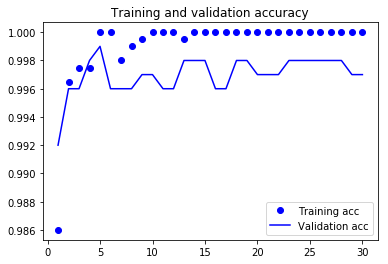

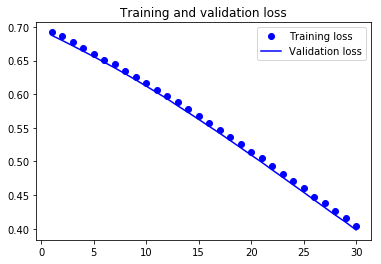

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

with 데이터 증식

In [11]:
from keras import  models, layers, optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150,150), 
    batch_size=20, 
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150,150), 
    batch_size=20, 
    class_mode='binary')

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), 
                loss='binary_crossentropy', 
                metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=100, 
    epochs=30, 
    validation_data = validation_generator, 
    validation_steps=50,
    verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 17s - loss: 0.4951 - acc: 0.7545 - val_loss: 0.2814 - val_acc: 0.8790
Epoch 2/30
 - 15s - loss: 0.2813 - acc: 0.8750 - val_loss: 0.2938 - val_acc: 0.8960
Epoch 3/30
 - 15s - loss: 0.2328 - acc: 0.9015 - val_loss: 0.1273 - val_acc: 0.9510
Epoch 4/30
 - 15s - loss: 0.1875 - acc: 0.9265 - val_loss: 0.1094 - val_acc: 0.9640
Epoch 5/30
 - 16s - loss: 0.1530 - acc: 0.9340 - val_loss: 0.1269 - val_acc: 0.9550
Epoch 6/30
 - 16s - loss: 0.1458 - acc: 0.9365 - val_loss: 0.0861 - val_acc: 0.9670
Epoch 7/30
 - 15s - loss: 0.1196 - acc: 0.9535 - val_loss: 0.0687 - val_acc: 0.9670
Epoch 8/30
 - 15s - loss: 0.1108 - acc: 0.9560 - val_loss: 0.0851 - val_acc: 0.9620
Epoch 9/30
 - 15s - loss: 0.0978 - acc: 0.9670 - val_loss: 0.1623 - val_acc: 0.9480
Epoch 10/30
 - 16s - loss: 0.1058 - acc: 0.9605 - val_loss: 0.0683 - val_acc: 0.9750
Epoch 11/30
 - 15s - loss: 0.0832 - acc: 0.9670 - val_loss: 0.1014 - val_ac

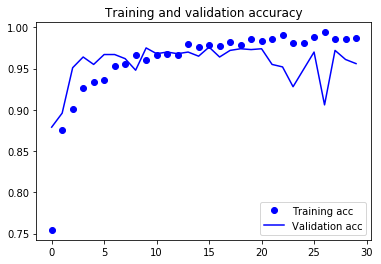

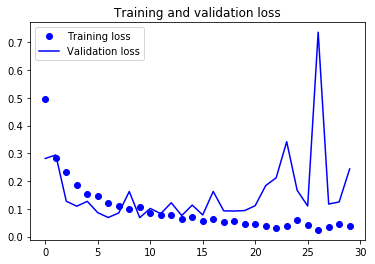

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [15]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5), 
                loss='binary_crossentropy', 
                metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=100, 
    epochs=100, 
    validation_data = validation_generator, 
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 17s 173ms/step - loss: 0.0235 - acc: 0.9925 - val_loss: 0.1237 - val_acc: 0.9770
Epoch 2/100
100/100 [==============================] - 16s 156ms/step - loss: 0.0122 - acc: 0.9960 - val_loss: 0.1425 - val_acc: 0.9730
Epoch 3/100
100/100 [==============================] - 16s 155ms/step - loss: 0.0102 - acc: 0.9955 - val_loss: 0.1564 - val_acc: 0.9720
Epoch 4/100
100/100 [==============================] - 16s 156ms/step - loss: 0.0177 - acc: 0.9955 - val_loss: 0.1502 - val_acc: 0.9740
Epoch 5/100
100/100 [==============================] - 16s 155ms/step - loss: 0.0139 - acc: 0.9955 - val_loss: 0.1678 - val_acc: 0.9740
Epoch 6/100
100/100 [==============================] - 16s 157ms/step - loss: 0.0133 - acc: 0.9940 - val_loss: 0.1344 - val_acc: 0.9750
Epoch 7/100
100/100 [==============================] - 16s 156ms/step - loss: 0.0099 - acc: 0.9965 - val_loss: 0.1405 - val_acc: 0.9770
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 16s 157ms/step - loss: 0.0018 - acc: 0.9995 - val_loss: 0.2701 - val_acc: 0.9720
Epoch 62/100
100/100 [==============================] - 16s 156ms/step - loss: 0.0025 - acc: 0.9990 - val_loss: 0.2528 - val_acc: 0.9750
Epoch 63/100
100/100 [==============================] - 16s 155ms/step - loss: 0.0090 - acc: 0.9985 - val_loss: 0.2032 - val_acc: 0.9790
Epoch 64/100
100/100 [==============================] - 16s 156ms/step - loss: 0.0043 - acc: 0.9975 - val_loss: 0.2296 - val_acc: 0.9730
Epoch 65/100
100/100 [==============================] - 16s 156ms/step - loss: 0.0022 - acc: 0.9990 - val_loss: 0.2577 - val_acc: 0.9710
Epoch 66/100
100/100 [==============================] - 16s 156ms/step - loss: 0.0060 - acc: 0.9985 - val_loss: 0.2172 - val_acc: 0.9790
Epoch 67/100
100/100 [==============================] - 16s 155ms/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.2322 - val_acc: 0.9780
Epoch 68/100
100/100 [===================

In [16]:
model.save('cats_and_dogs_small_4.h5')

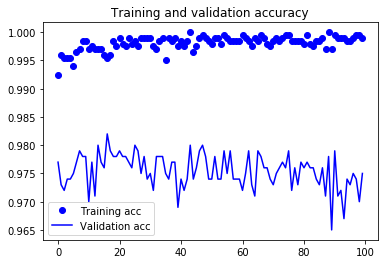

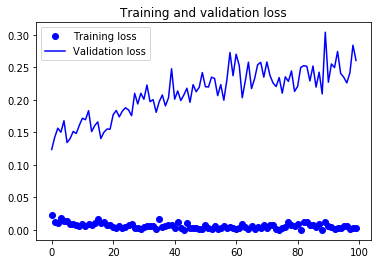

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

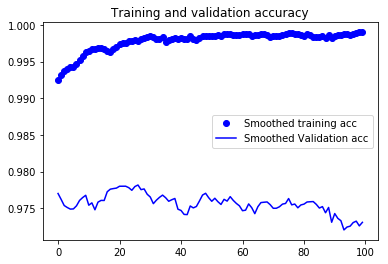

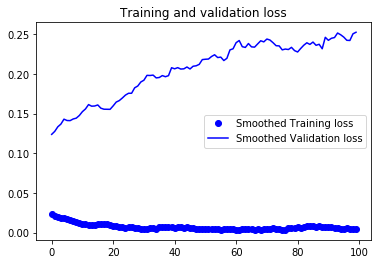

In [19]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9659999918937683
